# GET Data and Dependencies Installation

In [50]:
#!pip install albumentations
#!pip install labelme

# Collecting Images using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [7]:
uuid.uuid1()#for unique random image names

UUID('9901296b-a3c0-11ed-8bb8-b89a2a3b592e')

In [43]:
IMAGE_PATH = os.path.join('data','images') #Create Specified Path before running
number_images =30 # no of images collected 

In [44]:
#Collection of images ans saving with random  file name
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print("Collecting image {}".format(imgnum))
    ret, frame = cap.read()
    imgnum = os.path.join(IMAGE_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgnum,frame)
    cv2.imshow('frame',frame)
    time.sleep(1)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

# Annotate images with labelme

In [45]:
# Annotation of images maually using labelme
!labelme #to launch labelme

External WM_DESTROY received for  QWidgetWindow(0x2620c372590, name="LabelDialogClassWindow") , parent:  QWindow(0x0) , transient parent:  QWidgetWindow(0x2620bcc8b60, name="MainWindowClassWindow")


In [1]:
import tensorflow as tf
import json
import numpy as np
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# To Avoid Out Of Memory errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [3]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load Images into TF Data Pipeline

In [20]:
images = tf.data.Dataset.list_files('data/images/*.jpg',shuffle=False)

In [1]:
images.as_numpy_iterator().next() #to check the images are loaded into TF DataPipeline or not 

NameError: name 'images' is not defined

In [3]:
# To read the image
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [24]:
images = images.map(load_image)

In [3]:
images.as_numpy_iterator().next()

In [38]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [90]:
plt.style.use('dark_background')

In [40]:
image_geneator = images.batch(4).as_numpy_iterator()#to Bacth the images to Visualize

In [41]:
plot_images = image_geneator.next()# to generate new batch each time

In [1]:
fig, ax = plt.subplots(ncols=4,figsize=(20,20))# Visualize the Imgaes
for idx,image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# Partition unaugumented Data

### Manually Split the data into train,test and val

In [2]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folder,'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath,new_filepath)

# Image Augumentation on Images and Labels using Albumentsions

In [14]:
import albumentations as alb
#import cv2
#import json

In [3]:
augemntor = alb.Compose([alb.RandomCrop(width=450,height = 450),
                        alb.HorizontalFlip(p=0.5),
                        alb.RandomBrightnessContrast(p=0.2),
                        alb.RandomGamma(p=0.2),
                        alb.RGBShift(p=0.2),
                        alb.VerticalFlip(p=0.5)],
                        bbox_params=alb.BboxParams(format='albumentations',
                                                  label_fields=['class_labels']))

In [10]:
img = cv2.imread(os.path.join('data','train','images','6e1c35f4-a3cc-11ed-8b1c-b89a2a3b592e.jpg'))

In [21]:
img.shape

(480, 640, 3)

In [15]:
with open(os.path.join('data','train','labels','6e1c35f4-a3cc-11ed-8b1c-b89a2a3b592e.json'),'r') as f:
    labels=json.load(f)

In [18]:
labels['shapes'][0]['points']

[[245.62189054726372, 56.91542288557215],
 [432.6865671641791, 336.0199004975124]]

In [19]:
cords = [0,0,0,0]
cords[0] = labels['shapes'][0]['points'][0][0]
cords[1] = labels['shapes'][0]['points'][0][1]
cords[2] = labels['shapes'][0]['points'][1][0]
cords[3] = labels['shapes'][0]['points'][1][1]

In [20]:
cords

[245.62189054726372, 56.91542288557215, 432.6865671641791, 336.0199004975124]

In [24]:
cords = list(np.divide(cords,[640,480,640,480]))

In [25]:
augmented = augemntor(image=img,bboxes=[cords],class_labels=['face'])

In [4]:
augmented

In [5]:
cv2.rectangle(augmented['image'],
             tuple(np.multiply(augmented['bboxes'][0][:2],[450,450]).astype(int)),
             tuple(np.multiply(augmented['bboxes'][0][2:],[450,450]).astype(int)),
            (225,0,0),2)
plt.imshow(augmented['image'])

In [32]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augemntor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

# Load Augmented Data to TF Dataset

In [5]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg',shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x,(120,120)))
train_images = train_images.map(lambda x: x/255)

In [6]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg',shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x,(120,120)))
test_images = test_images.map(lambda x: x/255)

In [7]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg',shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x,(120,120)))
val_images = val_images.map(lambda x: x/255)

In [6]:
train_images.as_numpy_iterator().next()

In [15]:
def load_labels(label_path):
    with open(label_path.numpy(),'r',encoding="utf-8") as f:
        label = json.load(f)
    return [label['class']],label['bbox']

In [16]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json',shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [17]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json',shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [18]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json',shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [19]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.3896, 0.3088, 0.805 , 0.929 ], dtype=float16))

In [20]:
len(train_images),len(train_labels),len(test_images),len(test_labels),len(val_images),len(val_labels)

(3780, 3780, 840, 840, 780, 780)

In [21]:
train = tf.data.Dataset.zip((train_images,train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [22]:
test = tf.data.Dataset.zip((test_images,test_labels))
test = test.shuffle(5000)
test = test.batch(8)
test = test.prefetch(4)

In [23]:
val = tf.data.Dataset.zip((val_images,val_labels))
val = val.shuffle(5000)
val = val.batch(8)
val = val.prefetch(4)

In [26]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [34]:
data_sample = train.as_numpy_iterator()

In [44]:
res = data_sample.next()

In [7]:
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image,
             tuple(np.multiply(sample_coords[:2],[120,120]).astype(int)),
             tuple(np.multiply(sample_coords[2:],[120,120]).astype(int)),
            (225,0,0),2)
    ax[idx].imshow(sample_image)

# DataSet Done

In [51]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D,Dense,GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [52]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 8s 0us/step


In [53]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [60]:
def build_model():
    input_layer = Input(shape=(120,120,3))
    vgg = VGG16(include_top=False)(input_layer)
    
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048,activation='relu')(f1)
    class2 = Dense(1,activation='sigmoid')(class1)
    
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048,activation='relu')(f2)
    regress2 = Dense(4,activation='sigmoid')(regress1)
    
    facetraceker = Model(inputs=input_layer,outputs=[class2,regress2])
    return facetraceker

In [56]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.45   , 0.1716 , 0.773  , 0.703  ],
        [0.06934, 0.2522 , 0.392  , 0.784  ],
        [0.4028 , 0.3562 , 0.761  , 0.899  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.1082 , 0.     , 0.42   , 0.4192 ],
        [0.1426 , 0.1738 , 0.4963 , 0.702  ],
        [0.     , 0.1183 , 0.2423 , 0.646  ],
        [0.3142 , 0.1763 , 0.598  , 0.5933 ]], dtype=float16))

In [61]:
facetracker = build_model()

In [62]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_6[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_4 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                                

In [63]:
X,y = train.as_numpy_iterator().next()

In [64]:
X.shape

(8, 120, 120, 3)

In [65]:
classes,coords = facetracker.predict(X)

1/1 [==============================] - 11s 11s/step


In [66]:
classes,coords

(array([[0.6259827 ],
        [0.5655438 ],
        [0.4875559 ],
        [0.5614357 ],
        [0.5435158 ],
        [0.508376  ],
        [0.49812776],
        [0.49312785]], dtype=float32),
 array([[0.47765437, 0.3566393 , 0.6688724 , 0.47754717],
        [0.48655382, 0.35016719, 0.58746797, 0.42545885],
        [0.46498033, 0.5044519 , 0.7001665 , 0.37849224],
        [0.49110606, 0.4276948 , 0.71034276, 0.4090418 ],
        [0.47681537, 0.3935426 , 0.70594364, 0.47499365],
        [0.47160044, 0.46389845, 0.6655756 , 0.45223108],
        [0.4440068 , 0.39570346, 0.6911089 , 0.512267  ],
        [0.43711266, 0.4114664 , 0.69703305, 0.4691106 ]], dtype=float32))

In [71]:
batch_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batch_per_epoch

In [72]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [73]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [74]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [75]:
localization_loss(y[1],coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.5897815>

In [76]:
classloss(y[0],classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6609769>

In [77]:
regressloss(y[1],coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.5897815>

In [78]:
class FaceTracker(Model): 
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [79]:
model = FaceTracker(facetracker)

In [80]:
model.compile(opt, classloss, regressloss)

In [81]:
logdir='logs'

In [82]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [83]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
473/473 [==============================] - 136s 163ms/step - total_loss: 0.4310 - class_loss: 0.0970 - regress_loss: 0.3825 - val_total_loss: 0.0274 - val_class_loss: 9.8033e-05 - val_regress_loss: 0.0273
Epoch 2/10
473/473 [==============================] - 61s 119ms/step - total_loss: 0.1399 - class_loss: 0.0363 - regress_loss: 0.1217 - val_total_loss: 0.0177 - val_class_loss: 1.8538e-05 - val_regress_loss: 0.0176
Epoch 3/10
473/473 [==============================] - 63s 122ms/step - total_loss: 0.0777 - class_loss: 0.0266 - regress_loss: 0.0644 - val_total_loss: 0.0045 - val_class_loss: 6.0048e-04 - val_regress_loss: 0.0042
Epoch 4/10
473/473 [==============================] - 62s 120ms/step - total_loss: 0.0650 - class_loss: 0.0196 - regress_loss: 0.0552 - val_total_loss: 0.0094 - val_class_loss: 3.5979e-04 - val_regress_loss: 0.0092
Epoch 5/10
473/473 [==============================] - 62s 119ms/step - total_loss: 0.0318 - class_loss: 0.0091 - regress_loss: 0.0272 - val

In [84]:
hist.history

{'total_loss': [0.06083070859313011,
  0.008939027786254883,
  0.0240191537886858,
  0.003535144729539752,
  0.01846609264612198,
  0.006264660507440567,
  0.003710085293278098,
  0.0018395722145214677,
  0.0029364260844886303,
  0.005373204126954079],
 'class_loss': [0.004243467468768358,
  1.49011839312152e-06,
  0.012389547191560268,
  0.00012069572403561324,
  8.165889084921218e-06,
  0.003800752107053995,
  2.7299502107780427e-05,
  2.2531161448569037e-05,
  4.8937312385533005e-05,
  4.685134990722872e-05],
 'regress_loss': [0.05870897322893143,
  0.00893828272819519,
  0.017824379727244377,
  0.0034747968893498182,
  0.018462009727954865,
  0.004364284221082926,
  0.00369643559679389,
  0.0018283065874129534,
  0.002911957446485758,
  0.0053497785702347755],
 'val_total_loss': [0.027356108650565147,
  0.01765848509967327,
  0.004493439570069313,
  0.00939236767590046,
  1.633669137954712,
  0.008792918175458908,
  1.7707445621490479,
  0.002612058073282242,
  0.002719711279496550

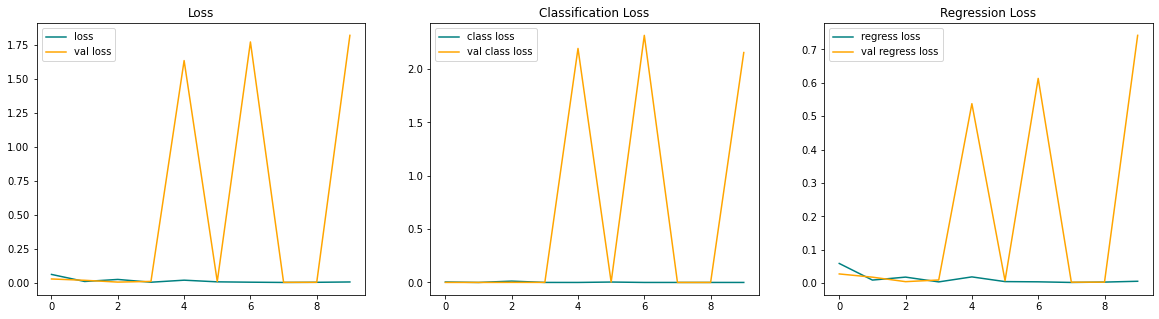

In [85]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [92]:
test_data = test.as_numpy_iterator()

In [93]:
test_sample = test_data.next()

In [94]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 17ms/step


In [8]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [11]:
from tensorflow.keras.models import load_model
import cv2
import tensorflow as tf
import numpy as np

In [12]:
#facetracker.save('facetracker.h5')

In [13]:
facetracker = load_model('facetracker.h5')

In [9]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()